En este notebook se desarrollan los gráficos que se usarán en la parte de resultados del TFM

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from src.datasets import daocensus, daocensus_text, to_microsoft
from src import paths

In [2]:
ORG_NAME = 'Decentraland'
ORG_PLATFORM = 'snapshot'
USE_ORG_NAMES: bool = False

SPLITS_FREQ = 'W-THU'
SPLITS_NORMALIZE: bool = True

# Exploración de datos de Decentraland

In [3]:
# dfptext = pd.read_csv('./snapshot_proposals.csv')[['proposal_id', 'title', 'description', 'start', 'end']]
# dfv, dfp = daocensus.get("./data/daos-census", ORG_NAME, ORG_PLATFORM)
# dfv['voter'] = dfv['voter'].astype('str')
# dfp = dfp.merge(dfptext, how='left', left_on='platform_proposal', right_on='proposal_id')
# dfp[['start', 'end']] = dfp[['start', 'end']].astype('datetime64')
# dfp = dfp.set_index('id')
dfv, dfp = daocensus_text.get("./data/daos-census-text", ORG_NAME, ORG_PLATFORM, use_org_names=USE_ORG_NAMES)
dfp = dfp.set_index('id')
print(dfv.info())
print(dfp.info())

Warning, removing 116560 votes without proposal
<class 'pandas.core.frame.DataFrame'>
Int64Index: 116560 entries, 0 to 116559
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   platform       116560 non-null  object        
 1   name           116560 non-null  object        
 2   id             116560 non-null  object        
 3   proposal       116560 non-null  category      
 4   deployment     116560 non-null  object        
 5   platform_vote  116560 non-null  object        
 6   voter          116560 non-null  category      
 7   date           116560 non-null  datetime64[ns]
 8   choice         116560 non-null  object        
 9   weight         116560 non-null  float64       
dtypes: category(2), datetime64[ns](1), float64(1), object(6)
memory usage: 8.5+ MB
None
<class 'pandas.core.frame.DataFrame'>
CategoricalIndex: 1943 entries, 0f4784fc-022a-5047-8bfe-e16ac3bd0984 to 629184e6-f8b2-5270

## Cuantas propuestas tenemos para entrenar en el dataset

In [4]:
from src.model_selection import timeFreqSplitCurrent, filter_current
from collections import defaultdict

In [5]:
sdd = defaultdict(list)

for dftrain, dftest, t, openproposals in timeFreqSplitCurrent(to_microsoft(dfv), SPLITS_FREQ, dfp.reset_index(), return_open=True, remove_not_in_train_col='userID', normalize=SPLITS_NORMALIZE):
    dftrain_filter = dftrain[dftrain['itemID'].isin(openproposals)]
    
    sdd['t'].append(t)
    sdd['open proposals'].append(len(openproposals))
    
    sdd['proposals in train'].append(dftrain['itemID'].nunique())
    sdd['votes in train'].append(len(dftrain))
    sdd['votes in open proposals (train)'].append(len(dftrain_filter))
    sdd['users in open proposals (train)'].append(dftrain_filter['userID'].nunique())
    sdd['votes in test'].append(len(dftest))
    sdd['users in train'].append(dftrain['userID'].nunique())
    sdd['users in test'].append(dftest['userID'].nunique())

sdf_all = pd.DataFrame(sdd).set_index('t')
sdf_all['vpp in open proposals (train)'] = sdf_all['votes in open proposals (train)'] / sdf_all['open proposals']
sdf_all['vpu in open proposals (train)'] = sdf_all['votes in open proposals (train)'] / sdf_all['users in open proposals (train)']
sdf_all['vpp test'] = sdf_all['votes in test'] / sdf_all['open proposals']
sdf_all['vpu test'] = sdf_all['votes in test'] / sdf_all['users in test']
sdf = sdf_all.tail(10)
print(sdf['votes in train'])
_style = sdf[['open proposals', 'votes in open proposals (train)', 'users in open proposals (train)', 'vpp in open proposals (train)', 'vpu in open proposals (train)', 'votes in test', 'users in test', 'vpp test', 'vpu test']].style
_style = _style.format_index('{:%G-W%V}').format(precision=2)
_style

t
2023-05-11    106129
2023-05-18    107387
2023-05-25    108802
2023-06-01    109556
2023-06-08    110250
2023-06-15    111195
2023-06-22    112105
2023-06-29    112925
2023-07-06    114417
2023-07-13    115984
Name: votes in train, dtype: int64


,open proposals,votes in open proposals (train),users in open proposals (train),vpp in open proposals (train),vpu in open proposals (train),votes in test,users in test,vpp test,vpu test
t,,,,,,,,,
2023-W19,18,1627,358,90.39,4.54,322,130,17.89,2.48
2023-W20,25,1346,305,53.84,4.41,713,147,28.52,4.85
2023-W21,19,1483,305,78.05,4.86,296,108,15.58,2.74
2023-W22,13,819,247,63.00,3.32,267,89,20.54,3.00
2023-W23,13,631,191,48.54,3.30,291,94,22.38,3.10
2023-W24,16,872,225,54.50,3.88,326,110,20.38,2.96
2023-W25,17,1136,278,66.82,4.09,331,127,19.47,2.61
2023-W26,10,838,278,83.80,3.01,204,92,20.40,2.22
2023-W27,21,1591,469,75.76,3.39,683,198,32.52,3.45


In [6]:
print(_style
  .format_index("\\textbf{{{}}}", escape="latex", axis=1)
  .to_latex()
)

\begin{tabular}{lrrrrrrrrr}
 & \textbf{open proposals} & \textbf{votes in open proposals (train)} & \textbf{users in open proposals (train)} & \textbf{vpp in open proposals (train)} & \textbf{vpu in open proposals (train)} & \textbf{votes in test} & \textbf{users in test} & \textbf{vpp test} & \textbf{vpu test} \\
t &  &  &  &  &  &  &  &  &  \\
2023-W19 & 18 & 1627 & 358 & 90.39 & 4.54 & 322 & 130 & 17.89 & 2.48 \\
2023-W20 & 25 & 1346 & 305 & 53.84 & 4.41 & 713 & 147 & 28.52 & 4.85 \\
2023-W21 & 19 & 1483 & 305 & 78.05 & 4.86 & 296 & 108 & 15.58 & 2.74 \\
2023-W22 & 13 & 819 & 247 & 63.00 & 3.32 & 267 & 89 & 20.54 & 3.00 \\
2023-W23 & 13 & 631 & 191 & 48.54 & 3.30 & 291 & 94 & 22.38 & 3.10 \\
2023-W24 & 16 & 872 & 225 & 54.50 & 3.88 & 326 & 110 & 20.38 & 2.96 \\
2023-W25 & 17 & 1136 & 278 & 66.82 & 4.09 & 331 & 127 & 19.47 & 2.61 \\
2023-W26 & 10 & 838 & 278 & 83.80 & 3.01 & 204 & 92 & 20.40 & 2.22 \\
2023-W27 & 21 & 1591 & 469 & 75.76 & 3.39 & 683 & 198 & 32.52 & 3.45 \\
2023-W28 & 

In [7]:
sdf.describe()

,open proposals,proposals in train,votes in train,votes in open proposals (train),users in open proposals (train),votes in test,users in train,users in test,vpp in open proposals (train),vpu in open proposals (train),vpp test,vpu test
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,17.500000,1892.600000,110875.000000,1283.600000,325.600000,381.500000,6986.300000,123.600000,72.309672,3.896316,21.428901,3.010979
std,4.719934,33.002357,3083.717454,552.792949,123.245194,173.231541,117.242436,33.230508,18.695872,0.618609,5.281827,0.732419
min,10.000000,1838.000000,106129.000000,631.000000,191.000000,204.000000,6863.000000,89.000000,48.538462,3.014388,15.578947,2.217391
25%,13.750000,1870.250000,108990.500000,846.500000,254.750000,292.250000,6912.500000,97.500000,56.625000,3.334923,18.284314,2.632029
50%,17.500000,1893.000000,110722.500000,1241.000000,291.500000,324.000000,6946.000000,118.500000,71.292717,3.980943,20.387500,2.852189
75%,20.500000,1913.500000,112720.000000,1564.000000,344.750000,369.250000,7028.250000,138.250000,82.363158,4.348586,21.923077,3.071809
max,25.000000,1941.000000,115984.000000,2493.000000,600.000000,713.000000,7234.000000,198.000000,108.391304,4.862295,32.523810,4.850340


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, '2023-W19'),
  Text(1, 0, '2023-W20'),
  Text(2, 0, '2023-W21'),
  Text(3, 0, '2023-W22'),
  Text(4, 0, '2023-W23'),
  Text(5, 0, '2023-W24'),
  Text(6, 0, '2023-W25'),
  Text(7, 0, '2023-W26'),
  Text(8, 0, '2023-W27'),
  Text(9, 0, '2023-W28')])

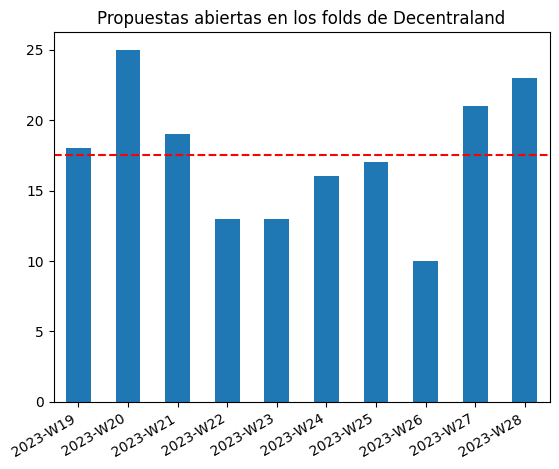

In [8]:
ax = sdf[['open proposals']].plot.bar(legend=False, xlabel='')
plt.axhline(sdf['open proposals'].mean(), c='red', linestyle='--')
ax.set_title(f'Propuestas abiertas en los folds de {ORG_NAME}')
ax.set_xticklabels(sdf.index.strftime('%G-W%V'))
plt.xticks(rotation=30, ha='right')
# TODO: Pintar horizonte con la media

<Axes: xlabel='t'>

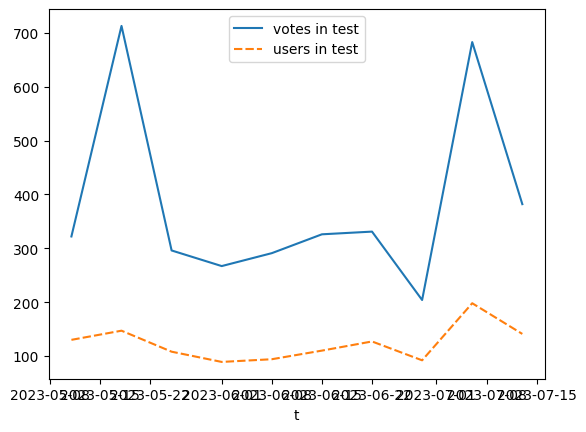

In [9]:
sns.lineplot(sdf[[
    # 'users in train (filtered)', 'votes in train (filtered)', 
    'votes in test', 'users in test',
]])

### Numero de propuestas relevantes
Además del número de propuestas abiertas, queremos saber cual es la _precision@k_ máxima, para ello es necesario saber no sólo el número de propuestas abiertas, si no en cuantas de esas propuestas votaron los usuarios. En términos de IR, necesitamos saber cual es el número de documentos relevantes, que seguramente sea menor que el número de documentos recuperados.

In [10]:
sdf['vpu in test'] = sdf['votes in test'] / sdf['users in test']
sdf

/tmp/ipykernel_91820/710207913.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdf['vpu in test'] = sdf['votes in test'] / sdf['users in test']


,open proposals,proposals in train,votes in train,votes in open proposals (train),users in open proposals (train),votes in test,users in train,users in test,vpp in open proposals (train),vpu in open proposals (train),vpp test,vpu test,vpu in test
t,,,,,,,,,,,,,
2023-05-11,18,1838,106129,1627,358,322,6863,130,90.388889,4.544693,17.888889,2.476923,2.476923
2023-05-18,25,1859,107387,1346,305,713,6886,147,53.840000,4.413115,28.520000,4.850340,4.850340
2023-05-25,19,1868,108802,1483,305,296,6910,108,78.052632,4.862295,15.578947,2.740741,2.740741
2023-06-01,13,1877,109556,819,247,267,6920,89,63.000000,3.315789,20.538462,3.000000,3.000000
2023-06-08,13,1886,110250,631,191,291,6937,94,48.538462,3.303665,22.384615,3.095745,3.095745
2023-06-15,16,1900,111195,872,225,326,6955,110,54.500000,3.875556,20.375000,2.963636,2.963636
2023-06-22,17,1909,112105,1136,278,331,6987,127,66.823529,4.086331,19.470588,2.606299,2.606299
2023-06-29,10,1915,112925,838,278,204,7042,92,83.800000,3.014388,20.400000,2.217391,2.217391
2023-07-06,21,1933,114417,1591,469,683,7129,198,75.761905,3.392324,32.523810,3.449495,3.449495


# Recomendador GNN

In [11]:
dfh = pd.read_csv(paths.hybrid_results(ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE))
dfg = dfh[dfh['model'] == 'gnn'].reset_index(drop=True)
dfg

,t,merge,map@10,map@5,ndcg@10,ndcg@5,precision@10,precision@5,recall@10,recall@5,model
0,2023-05-11,-,0.416497,0.355681,0.509048,0.424170,0.183846,0.236923,0.715775,0.473207,gnn
1,2023-05-18,-,0.317830,0.236382,0.433665,0.381793,0.272109,0.311565,0.501945,0.310225,gnn
2,2023-05-25,-,0.448630,0.399757,0.542098,0.504314,0.195370,0.281481,0.691264,0.562276,gnn
3,2023-06-01,-,0.486741,0.386744,0.600198,0.479281,0.268539,0.343820,0.856112,0.552369,gnn
4,2023-06-08,-,0.489618,0.390635,0.611936,0.506224,0.275532,0.353191,0.881480,0.585695,gnn
5,2023-06-15,-,0.402724,0.316985,0.530110,0.428835,0.237273,0.294545,0.803376,0.519384,gnn
6,2023-06-22,-,0.396455,0.336981,0.482358,0.418658,0.187402,0.251969,0.635449,0.455359,gnn
7,2023-06-29,-,0.600192,0.532555,0.714881,0.621583,0.221739,0.328261,1.000000,0.759653,gnn
8,2023-07-06,-,0.323837,0.246949,0.452107,0.366343,0.217677,0.243434,0.653289,0.392971,gnn
9,2023-07-13,-,0.315489,0.246473,0.445308,0.340205,0.178014,0.197163,0.669181,0.374164,gnn


# Recomendador Híbrido

In [12]:
dfm_baseline = pd.read_csv(f'./data/baseline/mp-freq-{ORG_NAME}-{SPLITS_FREQ}.csv')
dfm_baseline['model'] = 'mp'
dfm_all = pd.read_csv(f'./data/results/hybrid/{ORG_NAME}-{SPLITS_FREQ}.csv')
dfm_all = pd.concat((dfm_all, dfm_baseline))
dfm_all

FileNotFoundError: [Errno 2] No such file or directory: './data/baseline/mp-freq-Decentraland-W-THU.csv'